In [130]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
%matplotlib inline 
# from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 12, 4
import timeit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
import random
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import model_selection, metrics
from sklearn.grid_search import GridSearchCV # perform grid search

In [69]:
train_df = pd.read_csv("train.csv", header=0)
test_df = pd.read_csv("test.csv", header = 0)

In [32]:
# convert datetime column into multiple columns (year/month/day/hour/weekday)
dt = pd.to_datetime(train_df["datetime"]) # convert string to datetime type
train_df["year"] = dt.map(lambda x: x.year) 
train_df["month"] = dt.map(lambda x: x.month)
train_df["day"] = dt.map(lambda x: x.day)
train_df["hour"] = dt.map(lambda x: x.hour)
train_df["weekday"] = dt.map(lambda x: x.weekday())
train_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5


In [70]:
# convert datetime column into multiple columns (year/month/day/hour/weekday)
dt = pd.to_datetime(test_df["datetime"]) # convert string to datetime type
test_df["year"] = dt.map(lambda x: x.year) 
test_df["month"] = dt.map(lambda x: x.month)
test_df["day"] = dt.map(lambda x: x.day)
test_df["hour"] = dt.map(lambda x: x.hour)
test_df["weekday"] = dt.map(lambda x: x.weekday())
test_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,weekday
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,3
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,3
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,3


### Remove outliers 
From the figure Perceived Temerature VS Actual Temperature, there are some points far away from the diagonal line. Therefore, we remove the data points in the following steps.

In [33]:
train_clean = train_df[np.array(train_df["temp"]/train_df["atemp"])<2]

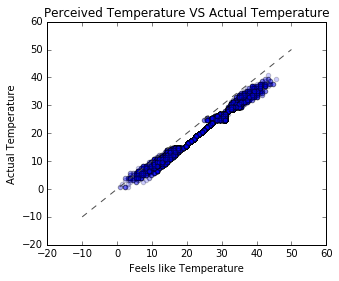

In [34]:
f, ax = plt.subplots(figsize=(5, 4))
ax.scatter(train_clean["atemp"], train_clean["temp"], alpha = 0.2)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3", color = "red")
ax.set_xlabel("Feels like Temperature")
ax.set_ylabel("Actual Temperature")
plt.title("Perceived Temperature VS Actual Temperature")
plt.show()

### Model Training

####  Feature Engineer
In the following section, We conducted one-hot-encoding to converse all categorical variables into binary arrays.

In [36]:
# weekday is dropped because it overlaps with workingday
# temp is dropped because it overlaps with atemp
# registered and casual are dropped because they should be response variable
train_all = train_df.drop(['datetime', 'weekday', 'temp', 'registered', 'casual'],axis = 1) # include all features and target
train_all.head(3)

,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,13.635,80,0.0,32,2011,1,1,2


In [71]:
test_all = test_df.drop(['datetime', 'weekday', 'temp'],axis = 1) # include all features and target
test_all.head(3) # features for testing model

,season,holiday,workingday,weather,atemp,humidity,windspeed,year,month,day,hour
0,1,0,1,1,11.365,56,26.0027,2011,1,20,0
1,1,0,1,1,13.635,56,0.0000,2011,1,20,1
2,1,0,1,1,13.635,56,0.0000,2011,1,20,2


In the above table, conduct one-hot-encoding for "season", "holiday", "workingday", "weather"

In [37]:
encode_feature = train_all[['season','holiday','workingday','weather']].values
enc = OneHotEncoder()
encode_result = enc.fit_transform(encode_feature).toarray()
print "encoded results for the first four categorical features: ", "\n"
print encode_result, np.shape(encode_result), "\n"

after_encode = np.concatenate([encode_result,train_all.ix[:, 4:]], axis = 1)
print "combine encoded features with other numerical features: ", "\n"
print after_encode, np.shape(after_encode), "\n"

col_names = train_all.columns
print col_names

encoded results for the first four categorical features:  

[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]] (10886, 12) 

combine encoded features with other numerical features:  

[[  1.   0.   0. ...,   1.   1.   0.]
 [  1.   0.   0. ...,   1.   1.   1.]
 [  1.   0.   0. ...,   1.   1.   2.]
 ..., 
 [  0.   0.   0. ...,  12.  19.  21.]
 [  0.   0.   0. ...,  12.  19.  22.]
 [  0.   0.   0. ...,  12.  19.  23.]] (10886, 20) 

Index([u'season', u'holiday', u'workingday', u'weather', u'atemp', u'humidity',
       u'windspeed', u'count', u'year', u'month', u'day', u'hour'],
      dtype='object')


#### Train Test Split
#### Version 1: without one-hot-encoding

In [38]:
# train and validation split. After one-hot-encoding, we have 19 features.
temp = train_all.values
header1 = list(col_names)
print header1

train_size = int(temp.shape[0]*0.67)

train_sample_indices = random.sample(range(temp.shape[0]),train_size) # random sample from temp data. No replacement
data1 = temp[train_sample_indices,:]

validation_sample_indices = [i for i in range(temp.shape[0]) if i not in train_sample_indices]
data2 = temp[validation_sample_indices,:]

header2 = header1

train_target = temp[train_sample_indices, header1.index('count')].astype(int) # target value for train data
train = np.delete(data1, header1.index('count'), axis = 1) # all features for model input
validation_target = temp[validation_sample_indices, header2.index('count')].astype(int) # target value for validation data
validation = np.delete(data2, header2.index('count'), axis = 1) 

assert(np.shape(train)[0] + np.shape(validation)[0] == np.shape(temp)[0]) # makesure the split is right
header1.remove('count')
np.shape(train_target), np.shape(train), np.shape(validation_target), np.shape(validation),np.shape(temp)

['season', 'holiday', 'workingday', 'weather', 'atemp', 'humidity', 'windspeed', 'count', 'year', 'month', 'day', 'hour']


((7293,), (7293, 11), (3593,), (3593, 11), (10886, 12))

#### version 2: with one-hot-encoding

In [39]:
# train and validation split. After one-hot-encoding, we have 19 features.
temp = train_all.values 
header1 = list(col_names)
print header1
train_size = int(temp.shape[0]*0.67)

train_sample_indices = random.sample(range(temp.shape[0]),train_size) # random sample from temp data. No replacement
data1 = temp[train_sample_indices,:]

validation_sample_indices = [i for i in range(temp.shape[0]) if i not in train_sample_indices]
data2 = temp[validation_sample_indices,:]

header2 = header1

train_target2 = temp[train_sample_indices, header1.index('count')].astype(int) # target value for train data
train2 = np.delete(data1, header1.index('count'), axis = 1) # all features for model input
validation_target2 = temp[validation_sample_indices, header2.index('count')].astype(int) # target value for validation data
validation2 = np.delete(data2, header2.index('count'), axis = 1) 

assert(np.shape(train2)[0] + np.shape(validation2)[0] == np.shape(temp)[0]) # makesure the split is right
header1.remove('count')
np.shape(train_target2), np.shape(train2), np.shape(validation_target2), np.shape(validation2),np.shape(temp)

['season', 'holiday', 'workingday', 'weather', 'atemp', 'humidity', 'windspeed', 'count', 'year', 'month', 'day', 'hour']


((7293,), (7293, 11), (3593,), (3593, 11), (10886, 12))

#### Here we have all training data and testing data. Ready to GO!

In [40]:
# Evaluation
def cal_rmlse(pred, actual):
    """
    evaluation of model
    parameters:
    -----------
    pred: array or list
        prediction
    actual: array or list
        actual target value
    return:
    -----------
    rmlse
    """
    rmlse = np.sqrt(np.mean((np.log(np.array(pred) + 1)- np.log(np.array(actual) + 1))**2))
    return rmlse
# test example
cal_rmlse([1,2,3],[2,6,2])

0.56717915832655263

### Model 1: Linear Regression
#### pair-wise scatter plot

In [41]:
X = sm.add_constant(train2)
result = sm.OLS(train_target2, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     417.6
Date:                Sat, 13 May 2017   Prob (F-statistic):               0.00
Time:                        20:59:22   Log-Likelihood:                -46502.
No. Observations:                7293   AIC:                         9.303e+04
Df Residuals:                    7281   BIC:                         9.311e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -1.648e+05   6753.169    -24.401      0.000     -1.78e+05 -1.52e+05
x1            -5.1957      6.433     -0.808      0.419       -17.806     7.415
x2           -13.9316     10.277     -1.356      0.175       -34.077     6.214
x3             0.1867      3.714      0.050      0.960        -7.094     7.467
x4            -4.1130      2.951     -1.394      0.163        -9.898     1.672
x5             6.1466      0.207     29.698      0.000         5.741     6.552
x6            -2.0633      0.109    -18.880      0.000        -2.278    -1.849
x7             0.5401      0.221      2.445      0.015         0.107     0.973
x8            81.9372      3.357     24.408      0.000        75.356    88.518
x9             9.0823      2.084      4.357      0.000         4.996    13.168
x10            0.5991      0.304      1.971      0.049         0.003     1.195
x11            7.8096      0.257     30.332      0.000         7.305     8.314
==============================================================================
Omnibus:                     1416.702   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2722.277
Skew:                           1.187   Prob(JB):                         0.00
Kurtosis:                       4.823   Cond. No.                     8.16e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.16e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### remove insignificant variables one by one and see other variables' significance

In [42]:
X = sm.add_constant(train2[:, [4,5,6,7,8,9,10]])
result = sm.OLS(train_target2, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     655.4
Date:                Sat, 13 May 2017   Prob (F-statistic):               0.00
Time:                        20:59:23   Log-Likelihood:                -46505.
No. Observations:                7293   AIC:                         9.303e+04
Df Residuals:                    7285   BIC:                         9.308e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -1.644e+05   6748.950    -24.353      0.000     -1.78e+05 -1.51e+05
x1             6.1493      0.207     29.746      0.000         5.744     6.555
x2            -2.1302      0.097    -21.917      0.000        -2.321    -1.940
x3             0.4962      0.218      2.272      0.023         0.068     0.924
x4            81.7243      3.355     24.360      0.000        75.148    88.301
x5             7.5025      0.514     14.604      0.000         6.495     8.510
x6             0.6103      0.304      2.008      0.045         0.014     1.206
x7             7.7774      0.256     30.388      0.000         7.276     8.279
==============================================================================
Omnibus:                     1428.091   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2761.799
Skew:                           1.193   Prob(JB):                         0.00
Kurtosis:                       4.844   Cond. No.                     8.15e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.15e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
lr = LinearRegression(fit_intercept=True)
lr.fit(train2[:, [4,5,6,7,8,9,10]], train_target2)
print lr.coef_

[  6.14928396  -2.13019679   0.49615641  81.7242977    7.50248565
   0.61032981   7.77743056]


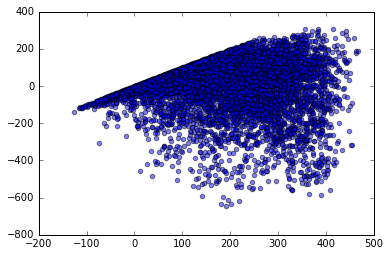

In [44]:
plt.scatter(lr.predict(train2[:, [4,5,6,7,8,9,10]]), lr.predict(train2[:, [4,5,6,7,8,9,10]])-train_target2, 
            alpha = 0.5)
plt.show()

diagnostics looks not good

### Baseline

In [45]:
# calculate error of predicting baseline (everyday count of rental is the same. 
# Everage Rental demand from training data)
avg_demand = np.mean(train_target)
base_rmlse = cal_rmlse(avg_demand, validation_target)
print "RMLSE using average demand: ", base_rmlse

RMLSE using average demand:  1.58658133807


### Model 2: Random Forests

#### Fit Random Forests

In [132]:
model = RandomForestRegressor(n_estimators = 50, max_depth = 5, oob_score = True, n_jobs = -1,random_state =0,
                              max_features = "auto", min_samples_leaf = 10)
model.fit(train, train_target)
print cal_rmlse(model.predict(validation), validation_target)

0.600025145968


In [133]:
model = RandomForestRegressor(n_estimators = 50, max_depth = 5, oob_score = True, n_jobs = -1,random_state =0,
                              max_features = "auto", min_samples_leaf = 10)
model.fit(train2, train_target2)
print cal_rmlse(model.predict(validation2), validation_target2)

0.59433717218


In [134]:
# increase n_estimator can increase the prediction result
model = RandomForestRegressor(n_estimators = 500, max_depth = 5, oob_score = True, n_jobs = -1,random_state =0,
                              max_features = "auto", min_samples_leaf = 10)
model.fit(train2, train_target2)
print cal_rmlse(model.predict(validation2), validation_target2)

0.592816354438


In [136]:
# max_depth selection
sample_max = [1,3,5,10,15, 20, 30]
for s in sample_max:
    rf = RandomForestRegressor(n_estimators=50, max_depth=s, random_state=0, max_features='auto', oob_score=True)
    rf.fit(train, train_target)
    scores = cross_val_score(rf, train, train_target, cv=10)
    print ("Accuracy: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.31049 (+/- 0.03)
Accuracy: 0.52688 (+/- 0.04)
Accuracy: 0.66596 (+/- 0.03)
Accuracy: 0.92374 (+/- 0.01)
Accuracy: 0.93628 (+/- 0.01)
Accuracy: 0.93710 (+/- 0.01)
Accuracy: 0.93674 (+/- 0.01)


In [137]:
# cv min_samples_leaf
sample_leaf = [5,10,20,30,40,50]
for leaf in sample_leaf:
    rf = RandomForestRegressor(n_estimators=50, max_depth=20, random_state=0, max_features='auto',
                                min_samples_leaf = leaf, oob_score=True)
    rf.fit(train, train_target)
    scores = cross_val_score(rf, train, train_target, cv=10)
    print ("Accuracy: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.93220 (+/- 0.02)
Accuracy: 0.92087 (+/- 0.02)
Accuracy: 0.89662 (+/- 0.02)
Accuracy: 0.87860 (+/- 0.02)
Accuracy: 0.85152 (+/- 0.02)
Accuracy: 0.82124 (+/- 0.02)


In [138]:
# a final model with max_depth 9 and min_samples_leaf 30 and n_estimators 500
model = RandomForestRegressor(n_estimators = 500, max_depth = 20, oob_score = True, n_jobs = -1,random_state =0,
                              max_features = "auto", min_samples_leaf = 5)
model.fit(train2, train_target2)
print "max_depth 9, min_samples_leaf 30, n_estimators 500", cal_rmlse(model.predict(validation2), validation_target2)

max_depth 9, min_samples_leaf 30, n_estimators 500 0.374477240691


In [139]:
# a final model (without one-hot-encoding) with max_depth 9 and min_samples_leaf 30 and n_estimators 500
model = RandomForestRegressor(n_estimators = 500, max_depth = 20, oob_score = True, n_jobs = -1,random_state =0,
                              max_features = "auto", min_samples_leaf = 5)
model.fit(train, train_target)
print "Parameters: max_depth 7, min_samples_leaf 10, n_estimators 500"
print "without one-hot-encoding rmlse: ", cal_rmlse(model.predict(validation), validation_target)

Parameters: max_depth 7, min_samples_leaf 10, n_estimators 500
without one-hot-encoding rmlse:  0.360664466931


This is better.

### Model 3: Gradient Boosting
#### Define a function help with model evaluation

In [173]:
def modelfit(alg, dtrain, dtrain_target, dvalidation, dvalidation_target, col_names, performCV = True, printFeatureImportance = True, cv_folds = 5):
    # fit the algorithm on the data
    alg.fit(dtrain, dtrain_target)
    # predict training dataset
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predictions[dtrain_predictions<0] = 0
    
    dvalidation_predictions = alg.predict(dvalidation)
    dvalidation_predictions[dvalidation_predictions<0] = 0
    
    # perform cross-validation
    if performCV:
        cv_score = cross_val_score(alg, dtrain, dtrain_target, cv = cv_folds)

    print "Model report: "
    print "RMLSE for Training Data:", cal_rmlse(dtrain_predictions, dtrain_target)
    print "RMLSE for Validation Data:",cal_rmlse(dvalidation_predictions, dvalidation_target)
    
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
#     Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, list(col_names)).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')   

#### baseline model (default gradient boosting setting)

Model report: 
RMLSE for Training Data: 0.783449282615
RMLSE for Validation Data: 0.765023948161
CV Score : Mean - 0.8567024 | Std - 0.008660531 | Min - 0.8430875 | Max - 0.8687586


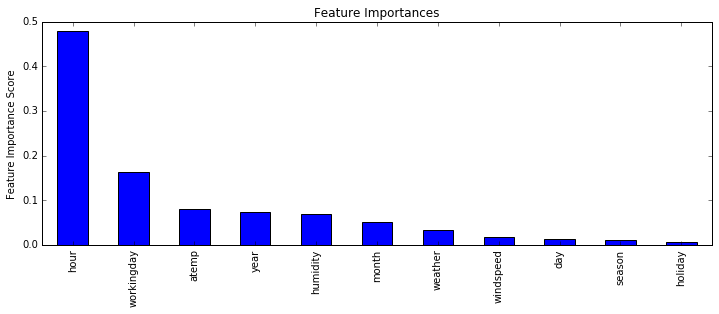

In [175]:
gbm0 = GradientBoostingRegressor(random_state = 0)
modelfit(gbm0, train, train_target, validation, validation_target, col_names[col_names != 'count'])

#### Parameter Tuning
##### initial model

Model report: 
RMLSE for Training Data: 0.262641803578
RMLSE for Validation Data: 0.356271131593
CV Score : Mean - 0.9429453 | Std - 0.006246919 | Min - 0.9312914 | Max - 0.9496747


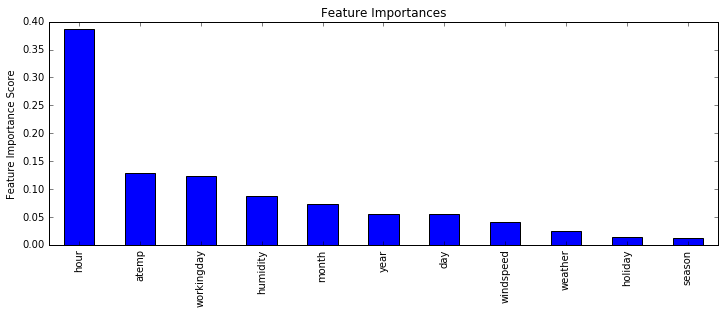

In [178]:
params = {'n_estimators': 500, 'max_depth': 8, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls', 'random_state': 0}
clf = GradientBoostingRegressor(**params)
modelfit(clf, train, train_target,validation, validation_target, col_names[col_names != 'count'])

In [179]:
param_test1 = {'n_estimators': range(200, 600, 10)}
gsearch1 = GridSearchCV(estimator=GradientBoostingRegressor(learning_rate = 0.01, min_samples_split=2, 
                                                            min_samples_leaf=50, max_depth = 8, max_features = 'sqrt',
                                                           random_state = 0), 
                        param_grid = param_test1, iid = False, cv = 5)
gsearch1.fit(train, train_target)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=8,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=50,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'n_estimators': [200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [180]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.74918, std: 0.00827, params: {'n_estimators': 200},
  mean: 0.75906, std: 0.00953, params: {'n_estimators': 210},
  mean: 0.76744, std: 0.00914, params: {'n_estimators': 220},
  mean: 0.77421, std: 0.00952, params: {'n_estimators': 230},
  mean: 0.78194, std: 0.00932, params: {'n_estimators': 240},
  mean: 0.78884, std: 0.00905, params: {'n_estimators': 250},
  mean: 0.79558, std: 0.00878, params: {'n_estimators': 260},
  mean: 0.80264, std: 0.00849, params: {'n_estimators': 270},
  mean: 0.80905, std: 0.00903, params: {'n_estimators': 280},
  mean: 0.81544, std: 0.00879, params: {'n_estimators': 290},
  mean: 0.82046, std: 0.00863, params: {'n_estimators': 300},
  mean: 0.82438, std: 0.00869, params: {'n_estimators': 310},
  mean: 0.82834, std: 0.00863, params: {'n_estimators': 320},
  mean: 0.83223, std: 0.00827, params: {'n_estimators': 330},
  mean: 0.83688, std: 0.00804, params: {'n_estimators': 340},
  mean: 0.84041, std: 0.00778, params: {'n_estimators': 350},
  mean: 

It seems the higher n_estimators, the higher the score is.

In [181]:
# tuning tree parameters max_depth and min_sample_split
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator=GradientBoostingRegressor(n_estimators = 500, learning_rate = 0.01, 
                                                            min_samples_leaf=50, max_features = 'sqrt',
                                                           random_state = 0, subsample = 0.8), 
                        param_grid = param_test2, iid = False, cv = 5)
gsearch2.fit(train, train_target)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=50,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=0,
             subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'min_samples_split': [200, 400, 600, 800, 1000], 'max_depth': [5, 7, 9, 11, 13, 15]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [182]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.78686, std: 0.00839, params: {'min_samples_split': 200, 'max_depth': 5},
  mean: 0.76317, std: 0.00595, params: {'min_samples_split': 400, 'max_depth': 5},
  mean: 0.74425, std: 0.00731, params: {'min_samples_split': 600, 'max_depth': 5},
  mean: 0.72738, std: 0.00882, params: {'min_samples_split': 800, 'max_depth': 5},
  mean: 0.71058, std: 0.00585, params: {'min_samples_split': 1000, 'max_depth': 5},
  mean: 0.84507, std: 0.00389, params: {'min_samples_split': 200, 'max_depth': 7},
  mean: 0.81096, std: 0.00562, params: {'min_samples_split': 400, 'max_depth': 7},
  mean: 0.77842, std: 0.00648, params: {'min_samples_split': 600, 'max_depth': 7},
  mean: 0.74680, std: 0.00685, params: {'min_samples_split': 800, 'max_depth': 7},
  mean: 0.72145, std: 0.00656, params: {'min_samples_split': 1000, 'max_depth': 7},
  mean: 0.86395, std: 0.00261, params: {'min_samples_split': 200, 'max_depth': 9},
  mean: 0.82138, std: 0.00472, params: {'min_samples_split': 400, 'max_depth': 9},
  

Model report: 
0.626955128101
CV Score : Mean - 0.8853326 | Std - 0.007144662 | Min - 0.8726113 | Max - 0.8925767


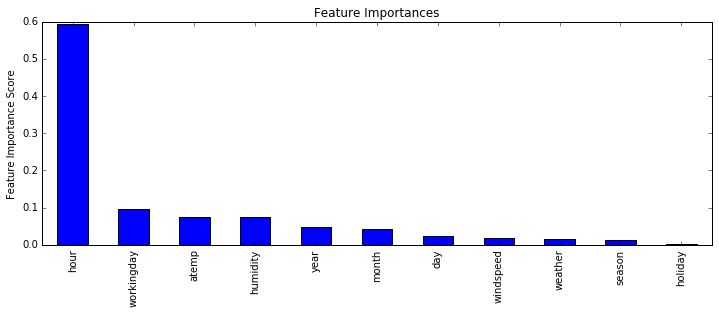

In [172]:
params = {'n_estimators': 90, 'learning_rate': 0.1, 'min_samples_split':500,
          'min_samples_leaf': 50, 'max_depth': 8, 'max_features': 'sqrt', 'random_state': 0}
clf = GradientBoostingRegressor(**params)
modelfit(clf, train, train_target, col_names[col_names != 'count'])

Model report: 
RMLSE for Training Data: 0.555986624092
RMLSE for Validation Data: 0.593019521189
CV Score : Mean - 0.8691965 | Std - 0.006177891 | Min - 0.8596572 | Max - 0.877554


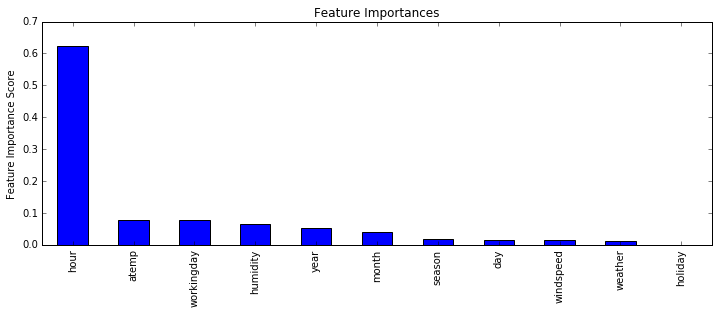

In [184]:
params = {'n_estimators': 500, 'max_depth': 15,'min_samples_leaf':50, 'min_samples_split': 200,
          'learning_rate': 0.01, 'loss': 'ls', 'random_state': 0, 'max_features': 'sqrt', 'subsample': 0.8}
                                                                                                    
clf2 = GradientBoostingRegressor(**params)
modelfit(clf2, train, train_target,validation, validation_target, col_names[col_names != 'count'])